In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
#initiate visualization library for jupyter notebook 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)
%matplotlib inline



#defining visualizaition functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

In [2]:
# loading data 
customers_ = pd.read_csv("Desktop/DS ToolKit/DataSet/olist_customers_dataset.csv")
order_items_ = pd.read_csv("Desktop/DS ToolKit/DataSet/olist_order_items_dataset.csv")
order_payments_ = pd.read_csv("Desktop/DS ToolKit/DataSet/olist_order_payments_dataset.csv")
orders_ = pd.read_csv("Desktop/DS ToolKit/DataSet/olist_orders_dataset.csv")

In [3]:
# displaying data shape
#dataset = [customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers, category_name_translation]
dataset = {
    'Customers': customers_,
    'Order Items': order_items_,
    'Payments': order_payments_,
    'Orders': orders_
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]


In [4]:
# displaying dataset column names
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



In [5]:
# checking for null values in datasets
for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Customers: False
Order Items: False
Payments: False
Orders: True


In [6]:
# taking count for dataset with missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



Although relating to the same transactions, the individual datasets holds different properties of an order, i would require methods like join and concat on unique keys to create a master dataset for analysis purpose.

In [7]:
# creating master dataframe 
order_payments_.head()
df1 = order_payments_.merge(order_items_, on='order_id')
df2 = df1.merge(orders_, on='order_id')
df = df2.merge(customers_, on='customer_id')
print(df.shape)

(117601, 22)


In [8]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [9]:
# cleaning up name columns
df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()
# engineering new/essential columns
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Changing the month attribute for correct ordenation
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)
#creating year month column
df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [10]:
# dropping non-needed columns
#df = df.drop(["product_name_lenght", "product_description_lenght", "product_photos_qty", "product_length_cm", "product_height_cm", "product_width_cm", "product_length_cm", "review_id","review_comment_title", "review_comment_message", "product_category_name"], axis=1)

In [11]:
# displaying summary staticstics of columns
df.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,115034,117601,117601,117601.000000,117601,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,93317,NaN,NaN,98665,7,98111,90173,81016,95663,449,95419,NaN,4110,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,63,NaN,NaN,63,115035,63,63,63,63,649,75,NaN,18590,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,NaN,120.824783,20.045990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35051.793097,NaN,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
std,NaN,0.726692,NaN,2.774223,267.592290,0.697706,NaN,NaN,NaN,184.479323,15.861315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29820.588877,NaN,NaN,10.162307,0.505065,3.229579,1.961257,5.325670,NaN,NaN,NaN,48.798820
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,NaN,39.900000,13.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000


In [12]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,delivery_against_estimated,order_delivered_customer_date,order_delivered_carrier_date,order_approved_at,payment_type,payment_installments,payment_value,order_item_id,product_id,order_purchase_timestamp,seller_id,shipping_limit_date,price,freight_value,customer_id,payment_sequential,order_status,month_y,month_year,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,order_id
Values,2567.000000,2567.000000,1245.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.182805,2.182805,1.058664,0.012755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [14]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
order_id                         115018 non-null object
payment_sequential               115018 non-null int64
payment_type                     115018 non-null object
payment_installments             115018 non-null int64
payment_value                    115018 non-null float64
order_item_id                    115018 non-null int64
product_id                       115018 non-null object
seller_id                        115018 non-null object
shipping_limit_date              115018 non-null datetime64[ns]
price                            115018 non-null float64
freight_value                    115018 non-null float64
customer_id                      115018 non-null object
order_status                     115018 non-null object
order_purchase_timestamp         115018 non-null datetime64[ns]
order_approved_at                115018 non-null datetime64[ns]
order_delivered_carrier_d

In [15]:
# displaying first 3 rows of master dataframe
df = df.query("month_year != '2016-12' and month_year != '2016-10'")
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712


The above master dataframe constitutes of the various independent dataset provided joined together via unique keys. Date columns have also been converted to datetime and new essential columns engineered for analysis purpose. 

# Monthly Revenue

In [16]:
#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df_revenue = df.groupby(['month_year'])['payment_value'].sum().reset_index()
df_revenue

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


# Monthly Revenue Growth Rate

In [17]:
#calculating for monthly revenie growth rate
# using pct_change() function to see monthly percentage change
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,month_year,payment_value,MonthlyGrowth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


# Monthly Active Customers

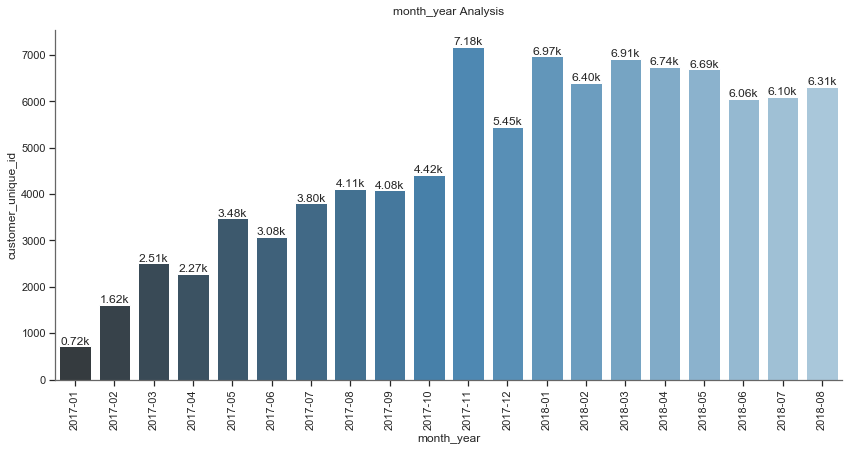

In [18]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_active = df.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Monthly Order Count

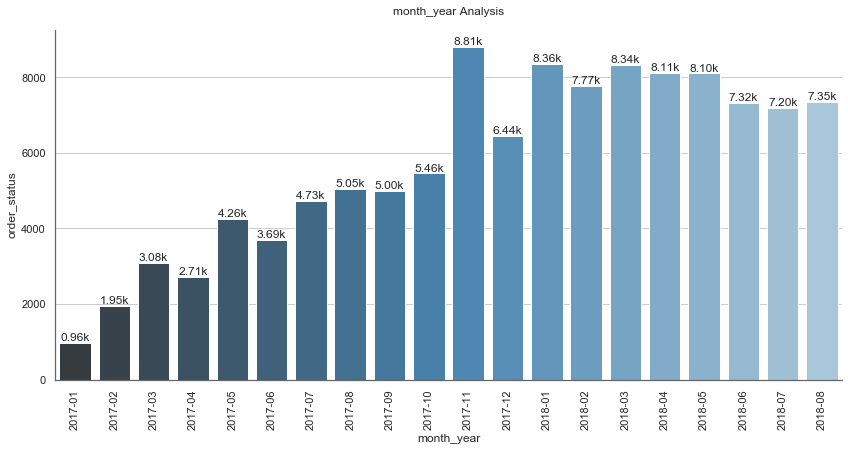

In [19]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_sales = df.groupby('month_year')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='order_status', df=df_monthly_sales, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Average Revenue per Customer Purchase

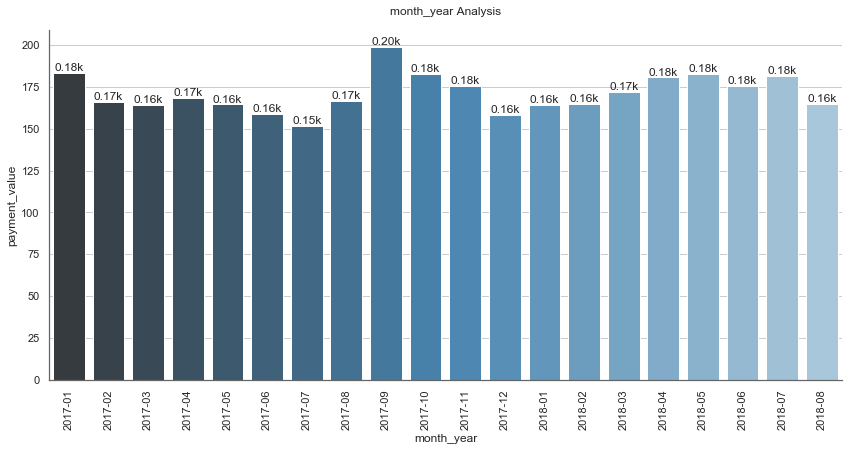

In [20]:
# create a new dataframe for average revenue by taking the mean of it
df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# New Customer Ratio

In [21]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
df = pd.merge(df, df_min_purchase, on='customer_unique_id')

In [22]:
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
df['usertype'] = 'New'
df.loc[df['month_y']>df['minpurchasedate'],'usertype'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = df.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201701,New,2017-01,176376.56
1,201702,Existing,2017-02,111.07
2,201702,New,2017-02,323704.88
3,201703,Existing,2017-03,596.38
4,201703,New,2017-03,505139.45
5,201704,Existing,2017-04,2677.76
6,201704,New,2017-04,453430.56
7,201705,Existing,2017-05,6733.95
8,201705,New,2017-05,694385.65
9,201706,Existing,2017-06,6956.06


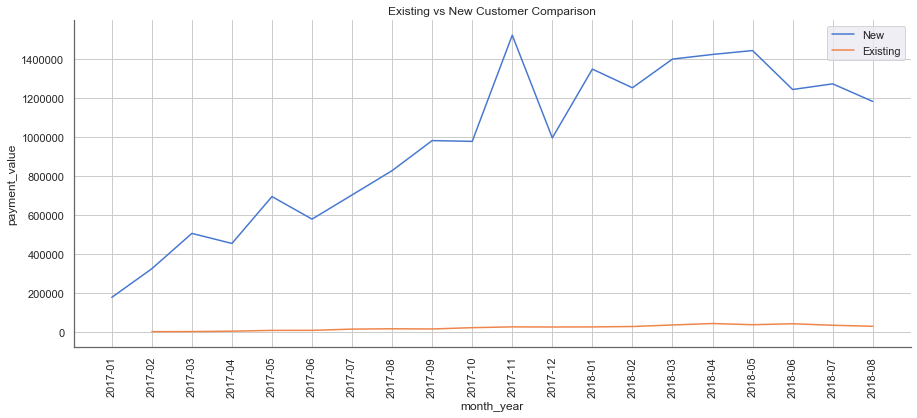

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# New Customer Ratio

In [24]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

#dropping nan values that resulted from first and last month
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

#print the dafaframe
df_user_ratio

,month_year,NewCusRatio
1,2017-02,808.000000
2,2017-03,500.600000
3,2017-04,132.764706
4,2017-05,123.214286
5,2017-06,77.871795
6,2017-07,76.591837
7,2017-08,71.175439
8,2017-09,51.333333
9,2017-10,49.193182
10,2017-11,57.868852


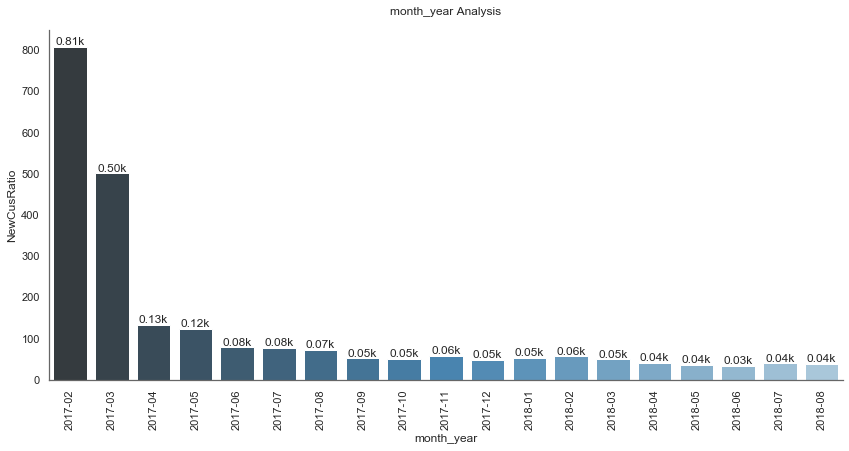

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Monthly Retention Rate

In [26]:
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total (using crosstab)

#identifying active users are active by looking at their revenue per month
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [27]:
#identifying active users are active by looking at their order count per month
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


In [28]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y,customer_unique_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [29]:
#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,RetainedUserCount,TotalUserCount,month_y,RetentionRate
0,3,2508,201703,0.001196
1,11,2274,201704,0.004837
2,14,3478,201705,0.004025
3,16,3076,201706,0.005202
4,16,3802,201707,0.004208
5,23,4114,201708,0.005591
6,32,4082,201709,0.007839
7,32,4417,201710,0.007245
8,37,7182,201711,0.005152
9,41,5450,201712,0.007523


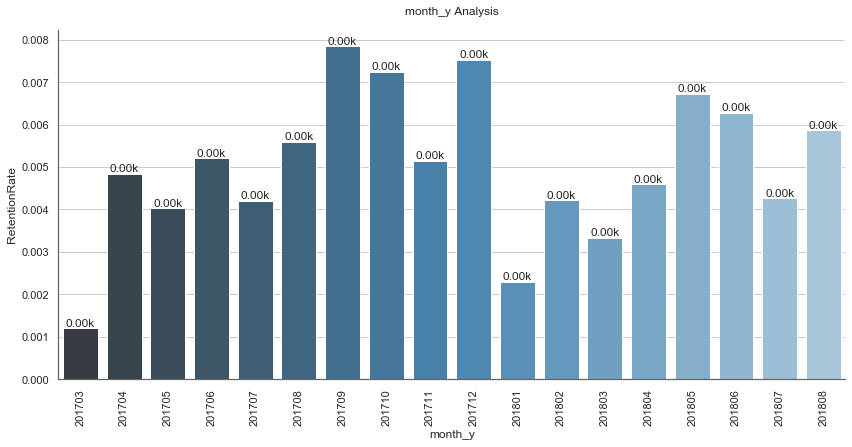

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_y', y='RetentionRate', df=df_retention, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Cohort Based Retention Rate

Cohorts are determined as first purchase year-month of the customers. I will be measuring what percentage of the customers retained after their first purchase in each month. This view will help unveil how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

In [31]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
new_column_names = [ 'm_' + str(column) for column in df_retention.columns]
df_retention.columns = new_column_names

In [32]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)

In [33]:
#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

#showing new cohort based retention table
df_retention

,TotalUserCount,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
month_y,,,,,,,,,,,,,,,,,,,,
201702,1618,1.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201703,2508,NaN,1.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201704,2274,NaN,NaN,1.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201705,3478,NaN,NaN,NaN,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201706,3076,NaN,NaN,NaN,NaN,1.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201707,3802,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201708,4114,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201709,4082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201710,4417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00


# Customer Segmentation

Customers who shop on Olist have different needs and they have their own different profile. We should adapt our actions depending on that.

RFM stands for Recency - Frequency - Monetary Value, I will be using this metrics to segment customers. Theoretically we will have segments like below:
Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

# Recency

To calculate recency, we need to find out most recent purchase date of each customer and see for how many days they are inactive. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [34]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,a8b9d3a27068454b1c98cc67d4e31e6f,64
2,6f70c0b2f7552832ba46eb57b1c5651e,260
3,87695ed086ebd36f20404c82d20fca87,266
4,4291db0da71914754618cd789aebcd56,28


In [35]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count    114681.000000
mean        235.937671
std         150.795167
min           0.000000
25%         113.000000
50%         217.000000
75%         344.000000
max         601.000000
Name: Recency, dtype: float64

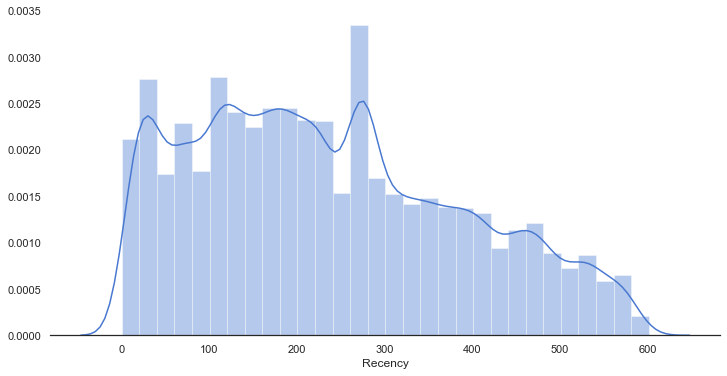

In [36]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

I will be applying K-means clustering to assign a recency score to each customer. But there is need to tell how many clusters i need to K-means algorithm. To find this out, I will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

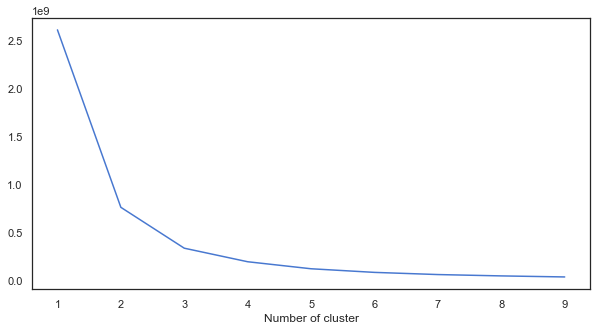

In [37]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 4 is the optimal number of clusters. Based on business requirements, I can go ahead with less or more clusters. In tis case i will be selecting 5.

In [38]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [39]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,14520.0,503.543595,42.605553,440.0,467.0,496.0,537.0,601.0
1,18512.0,374.883967,33.993350,318.0,345.0,374.0,404.0,439.0
2,27138.0,259.977154,30.867787,207.0,231.0,265.0,281.0,317.0
3,29976.0,152.353082,30.925276,101.0,125.0,153.0,180.0,206.0
4,24535.0,48.260322,27.790662,0.0,24.0,44.0,73.0,100.0


From the above table the recency clusters have different characteristics. The customers in Cluster 4 are very recent compared to Cluster 3 and 2.
Hence cluster 4 covers the most active customers wheras cluster 0 covers the most inactive

# Frequency

To create frequency clusters, i will need to find total number orders for each customer, after which i cango ahead and place them in various clusters

In [40]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

In [41]:
# getting summary statistics of the recency table
df_user.Frequency.describe()

count    114681.000000
mean          1.777496
std           2.774387
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          75.000000
Name: Frequency, dtype: float64

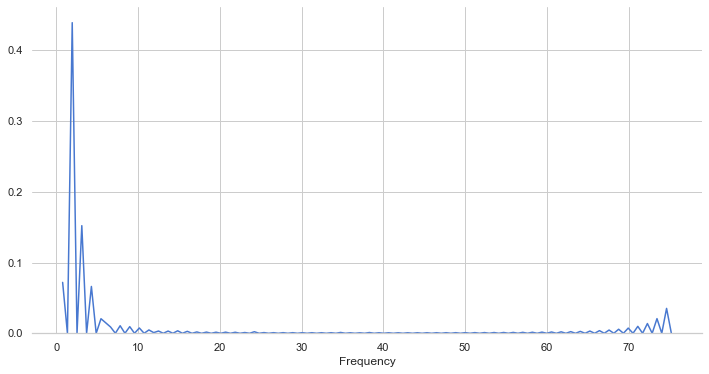

In [42]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

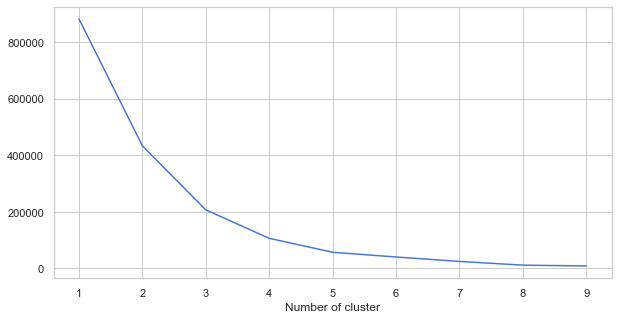

In [43]:
sse={}
df_Frequency = df_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_Frequency)
    df_Frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [44]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,99875.0,1.207900,0.405807,1.0,1.0,1.0,1.0,2.0
1,12870.0,4.039005,1.186489,3.0,3.0,4.0,5.0,7.0
2,1464.0,10.831967,2.252463,8.0,9.0,11.0,12.0,16.0
3,397.0,24.536524,6.099081,18.0,20.0,22.0,24.0,38.0
4,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


As the same notation as recency clusters, high frequency number indicates better customers.

# Revenue
Let’s see how our customer base looks like when I cluster them based on revenue. I will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [45]:
df.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y,minpurchasedate,usertype
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804,201804,New


In [46]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

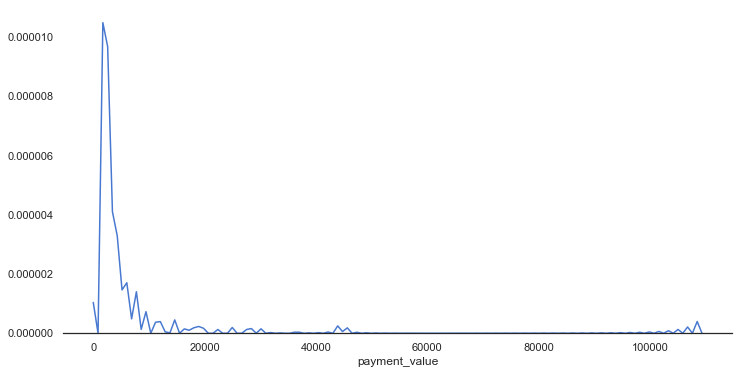

In [47]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

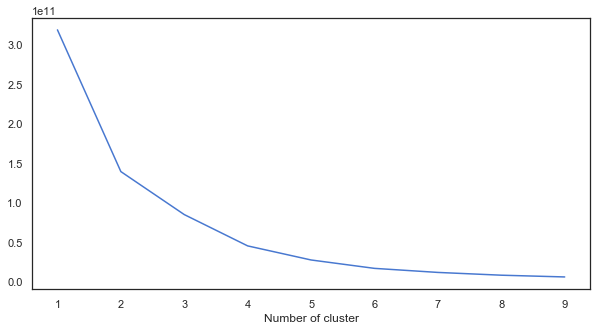

In [48]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [49]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,108364.0,194.082194,194.294684,9.59,67.5900,124.44,234.46,1059.93
1,5366.0,1924.926368,835.210242,1060.80,1286.4025,1639.66,2258.40,4513.32
2,713.0,7106.523829,2117.325473,4534.56,5355.6000,6512.28,8108.64,12490.88
3,184.0,20278.110435,5207.417793,14196.28,16313.6000,19174.38,25051.89,30186.00
4,46.0,43587.292174,2837.177072,36489.24,44048.0000,44048.00,45256.00,45256.00
5,8.0,109312.640000,0.000000,109312.64,109312.6400,109312.64,109312.64,109312.64


# Overall Score

After creating various metric scores (cluster numbers) for recency, frequency & revenue. now i will proceed to create an overall score out of them:

In [50]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,502.967092,1.207968,166.830748
1,384.910125,1.377323,199.515347
2,272.271837,1.469128,222.790089
3,169.007065,1.585884,256.792263
4,69.228495,1.693655,305.932804
5,103.436646,6.015805,1223.685095
6,91.547833,6.757848,3099.777668
7,115.689977,12.109557,6057.909184
8,154.866667,12.030303,23948.324485


The scoring above clearly shows us that customers with score 12 is our best customers whereas 0 is the worst.
To keep things simple, better we name these scores:
0 to 4: Low Value
5 to 7: Mid Value
8+: High Value

In [51]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

In [52]:
df_user.head()

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,708ab75d2a007f0564aedd11139c7708,125,3,1,0,99.33,0,3,Low-Value
1,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
2,6e3c218d5f0434ddc4af3d6a60767bbf,114,3,2,0,192.24,0,3,Low-Value
3,0ae522661311f598df20272643d39ce6,160,3,1,0,157.45,0,3,Low-Value
4,d386a136dc889cf681443061874caad8,113,3,1,0,136.71,0,3,Low-Value


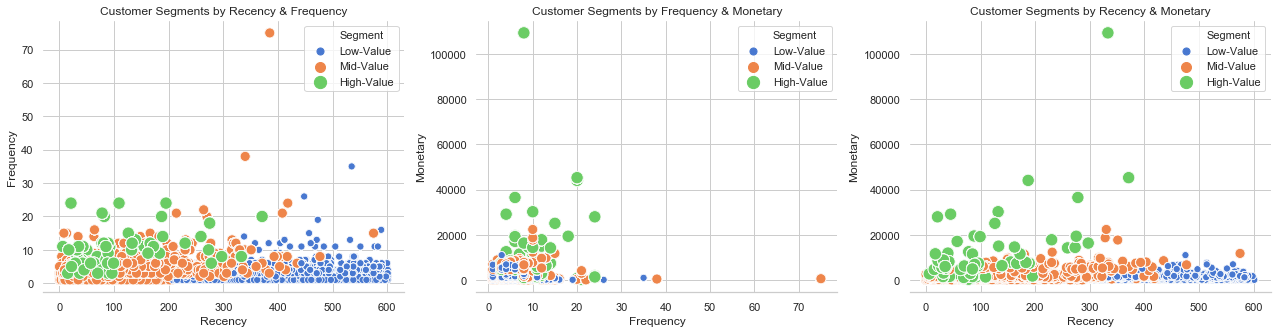

In [53]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

The abve plot clearly shows how the various customers are segmented according to their RFM scores 

High-Value customers(green dots): These are the top performing customers and for this set of customers the best action would be to improve Retention
Mid-Value customers(orange dots): These set of customers the best action would be to improve Frequency + Retention
Low-Value customers(blue dots): These set of customers the best action would be to improve Frequency